# Workflow Structure

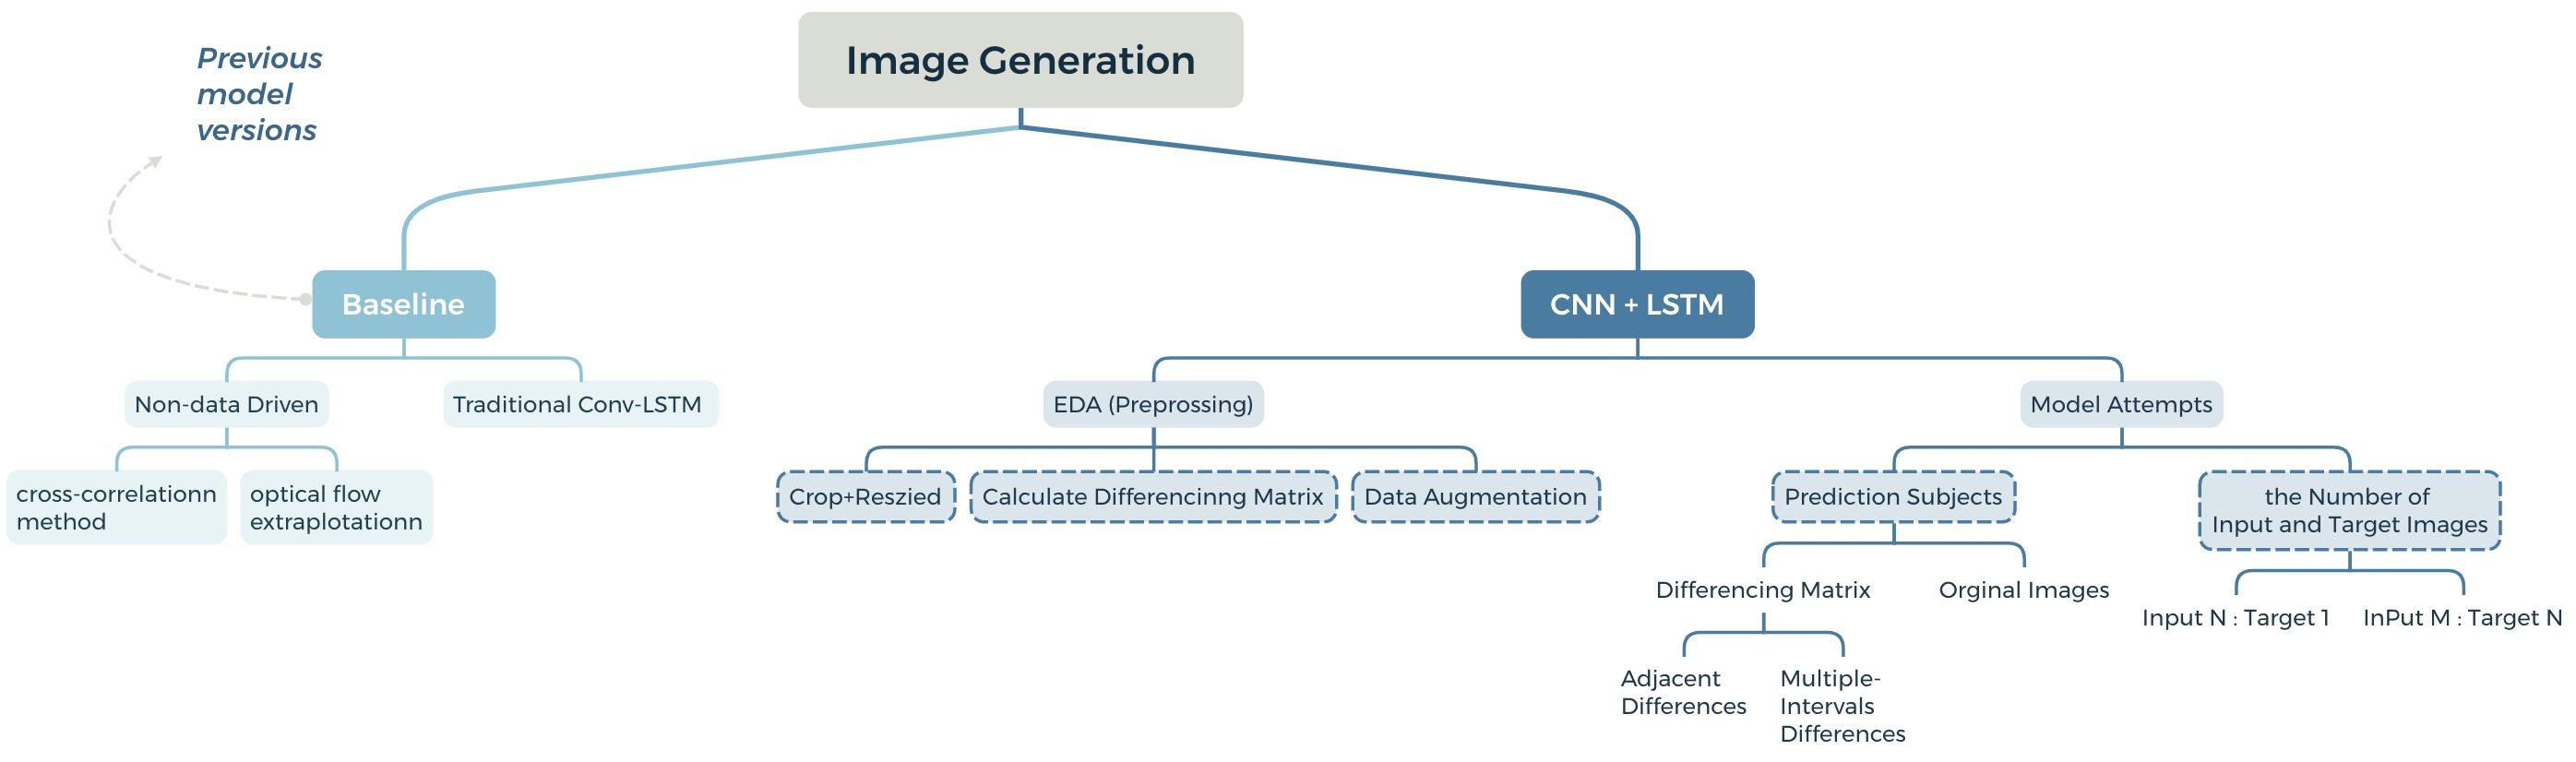

# Model: CNN + LSTM



- **Main Method:** Differencing

- **Improvement:** Multiple-intervals Differencing


### Import libraries

In [1]:
import cv2
import numpy as np
import json
import os
import pandas as pd
from glob import glob
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.optim as optim
import sys
sys.path.append('forecaster/')
from forecaster.extract_time import extract_time_series, time_series_difference
from forecaster.crop_resized import crop_center, process_and_save_images_custom_name, crop_images
from forecaster.differencing_matrix import calculate_pixel_difference, get_sorted_image_paths, adjust_differences, compute_sliding_sums
from livelossplot import PlotLosses

# Part 1: Data Inspection
### 1.1 Explore Time Difference of Adjacent Images

After taking a rough look at the data, we found that most of the time differences between adjacent images were 1800, so we need to inspect the data first and see the distribution of time differences.

In [25]:
path = 'tst_*_features.json'
final_df = extract_time_series(path)
time_series_difference(final_df)

,time_diff,count
0,1800.0,94
1,1799.0,50
2,1801.0,44
3,3600.0,25
4,3599.0,13
5,1802.0,10
6,3601.0,7
7,1798.0,4
8,3598.0,3
9,3603.0,1


#### Conclusion

As shown above, the time diffs of adjacdent images are all mutiples of 1800 (error less then 5). So we can regard 1800 as a normal time diff. Methods like interpolation should be considered to solve the large interval problem.

### 1.2 Choose to train 30 storm sets or 1 storm set

Each folder represents a storm track. Obviously, the rotation and movement patterns of each storm are different. Therefore, we believe that the image generation model of surprise storm does not need to pre-train 30 storm sets to achieve generalization. Therefore, we only use the images of the surprise storm itself as training data.

# Part 2: Data Pre-processing

### 2.1 Set Parameters

- **Image size:** 366*366 (the original size)

- **Difference step:** 3

- **Input length:** 3

- **Target (Output) length:** 3


In [8]:
crop_size = 366  # Size after cropping, originally 366
step_length = 3  # Difference step
seq_length = 3  # Length of input used for training
forecast_horizon = 3  # Length of the target
sequential_number = seq_length + forecast_horizon  # Length of a data set, including input and target

**Conclusion: Most time_diff was about 1800 and 3600. Therefore, we removed the outliers which are larger than 5400 and interpolated the missing images.**

### 2.2 Calculate the differences and interplote values in where the time diffs are multiple 1800.

In [16]:
sorted_image_paths = get_sorted_image_paths('/Users/pl/lilian/tst/')
adjusted_diffs = compute_sliding_sums(adjust_differences(sorted_image_paths),step_length)
print(f'adjusted_diffs is {len(adjusted_diffs)}.')

adjusted_diffs is 299.


In [17]:
difference_array = np.array(adjusted_diffs)
difference_tensor = torch.tensor(difference_array)
difference_tensor.shape

torch.Size([299, 366, 366])

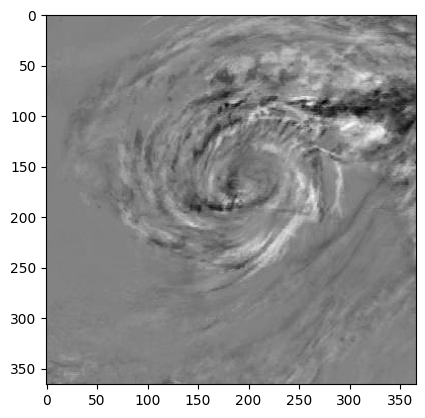

(tensor(-216., dtype=torch.float64), tensor(199., dtype=torch.float64))

In [18]:
plt.imshow(adjusted_diffs[-1], cmap='gray')
plt.show()
difference_tensor.min(),difference_tensor.max()

### 2.3 Find indexes where time series is not sequential

In [27]:
train_index_df

,index,time_diff
0,0,NaN
1,1,1800.0
2,2,1801.0
3,3,1799.0
4,4,1800.0
...,...,...
250,250,3601.0
251,251,1800.0
252,252,1800.0
253,253,1800.0


In [28]:
final_df

,storm_id,relative_time,ocean,time_diff
0,tst,0,1,NaN
1,tst,1800,1,1800.0
2,tst,3601,1,1801.0
3,tst,5400,1,1799.0
4,tst,7200,1,1800.0
...,...,...,...,...
250,tst,539999,1,3601.0
251,tst,541799,1,1800.0
252,tst,543599,1,1800.0
253,tst,545399,1,1800.0


In [29]:
train_index_df = final_df
# Select 'time_diff' column
train_index_df = train_index_df['time_diff']
# Reset index of the DataFrame
train_index_df = train_index_df.reset_index()
train_index_df.iloc[0, train_index_df.columns.get_loc('time_diff')] = 0
# Convert 'time_diff' to integer type
train_index_df.time_diff = train_index_df.time_diff.astype(int)
# Display value counts of 'time_diff'
train_index_df.time_diff.value_counts()

# Find indices to expand
# Select rows where 'time_diff' is between 3595 and 3605
indices_to_expand = train_index_df[(train_index_df['time_diff'] <= 3605) & (train_index_df['time_diff'] >= 3595)].index
print(len(indices_to_expand))
indices_to_expand
# Display value counts of 'time_diff' again
train_index_df.time_diff.value_counts()

# Expand selected indices
for i in range(len(indices_to_expand)):
    idx = i + indices_to_expand[i]
    row_to_duplicate = train_index_df.loc[idx]
    # Duplicate the row and insert it back into the DataFrame
    train_index_df = pd.concat([train_index_df.iloc[:idx+1], pd.DataFrame([row_to_duplicate]), train_index_df.iloc[idx+1:]]).reset_index(drop=True)
# Display value counts of 'time_diff' again
train_index_df.time_diff.value_counts()

# Replace effective intervals: Change 'time_diff' to 1 for rows with intervals of 1800 or 3600
train_index_df.loc[train_index_df['time_diff'] < 4000, 'time_diff'] = 1    

# Replace ineffective intervals: Change 'time_diff' to 0 for rows with intervals greater than 3600
train_index_df.loc[train_index_df['time_diff'] > 4000, 'time_diff'] = 0


# Step 1: Mark all rows with continuous 1s less than 'sequential_number' as 1
train_index_df['group'] = (train_index_df['time_diff'] != train_index_df['time_diff'].shift()).cumsum()
group_counts = train_index_df.groupby('group')['time_diff'].transform('size')
train_index_df['label'] = 0
train_index_df.loc[(train_index_df['time_diff'] == 1) & (group_counts < sequential_number), 'label'] = 1

# Step 2: Mark all rows originally 0 as 2
train_index_df.loc[train_index_df['time_diff'] == 0, 'label'] = 2

# Step 3: Mark all rows with continuous 1s greater than or equal to 'sequential_number' as 3
train_index_df.loc[(train_index_df['time_diff'] == 1) & (group_counts >= sequential_number), 'label'] = 3

# Step 4: Apply changes accordingly
# Change 'time_diff' to 0 for rows marked as 1
train_index_df.loc[train_index_df['label'] == 1, 'time_diff'] = 0
# For each group marked as 3, change 'time_diff' to 0 for the last three 1s
train_index_df.loc[train_index_df['label'] == 3, 'time_diff'] = train_index_df.groupby('group').cumcount(ascending=False).ge(sequential_number-1).astype(int)
# Remove rows marked as 2
train_index_df = train_index_df[train_index_df['label'] != 2].drop(columns=['group', 'label'])

# Output result
print(train_index_df)

50
     index  time_diff
0        0          1
1        1          1
2        2          1
3        3          1
4        4          1
..     ...        ...
300    250          0
301    251          0
302    252          0
303    253          0
304    254          0

[305 rows x 2 columns]


# Part 3: Architectures

### 3.1 network design

**CNN-LSTM-pytorch (the final version model)**

In [76]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 91 * 91, 256)  # crop_size/2/2 = 91(32)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        return x


In [77]:
class LSTMModel(nn.Module):
    def __init__(self, seq_length, forecast_horizon):
        super(LSTMModel, self).__init__()
        self.cnn = CNN()
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, forecast_horizon * 366 * 366)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.lstm(r_in)
        r_out2 = self.fc(r_out[:, -1, :])
        output = r_out2.view(batch_size, forecast_horizon, 366, 366)
        return output


**more Complicated Network (not in use)**

In [706]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 新增层
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Dropout层
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * crop_size * crop_size, 512)  # 366/2/2/2 = 45.75, 近似为45
        self.fc2 = nn.Linear(512, 256)  # 新增层

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout层
        x = F.relu(self.fc2(x))
        return x

In [707]:
class LSTMModel(nn.Module):
    def __init__(self, seq_length, forecast_horizon):
        super(LSTMModel, self).__init__()
        self.cnn = CNN()
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=2, batch_first=True)  # 增加层数和隐藏单元数量
        self.dropout = nn.Dropout(0.5)  # Dropout层
        self.fc = nn.Linear(256, forecast_horizon * crop_size * crop_size)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.lstm(r_in)
        r_out = self.dropout(r_out)  # Dropout层
        r_out2 = self.fc(r_out[:, -1, :])
        output = r_out2.view(batch_size, forecast_horizon, crop_size, crop_size)
        return output

# Part 4: Data Split

**rotate the images (not in use)**

In [157]:
class RotatedHurricaneDataset(Dataset):
    def __init__(self, inputs, targets, rotation_range=(-30, 30)):
        self.inputs = inputs
        self.targets = targets
        self.rotation_range = rotation_range

    def __len__(self):
        # Return the length of the dataset
        return len(self.inputs)

    def __getitem__(self, idx):
        # Retrieve input and target images by index
        input_imgs = self.inputs[idx]
        target_imgs = self.targets[idx]
        print(input_imgs)
        print(target_imgs)
        print(input_imgs.shape)
        print(target_imgs.shape)
        
        # Generate a random rotation angle
        angle = torch.FloatTensor(1).uniform_(*self.rotation_range).item()
        
        # Define rotation transform
        rotate_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation((angle, angle)),
            transforms.ToTensor()
        ])
        
        # Apply the same random rotation to both input and target
        input_img_rotated = torch.stack([rotate_transform(img.squeeze(0)) for img in input_imgs.permute(3, 0, 1, 2)])  # Apply rotation to each image in the input
        target_img_rotated = rotate_transform(target_imgs.squeeze(0).squeeze(0))  # Apply rotation to the target image
        
        return input_img_rotated, target_img_rotated

# # Use the custom dataset class
# train_dataset = RotatedHurricaneDataset(train_inputs, train_targets)
# test_dataset = RotatedHurricaneDataset(test_inputs, test_targets)

# # Data loaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [78]:
# Combine input sequential with target sequential to form a shuffle window
input_seqs = []
target_seqs = []

for i in range(len(adjusted_diffs)-sequential_number):
    input_seqs.append(difference_tensor[i : i+seq_length].unsqueeze(1))  # Add the channel dimension
    target_seqs.append(difference_tensor[i+seq_length : i+seq_length+forecast_horizon].unsqueeze(0).unsqueeze(1))  # Add batch_size and channel dimensions
        
input_seqs = torch.stack(input_seqs)
target_seqs = torch.stack(target_seqs)

# Ensure they are float type
input_seqs = input_seqs.float()
target_seqs = target_seqs.float()

# Split train (first 80%) and test dataset (last 20%)
split_idx = int(input_seqs.shape[0] * 0.2)
train_inputs, test_inputs = input_seqs[split_idx:], input_seqs[:split_idx]
train_targets, test_targets = target_seqs[split_idx:], target_seqs[:split_idx]

# Randomly split the dataset into training and testing sets, with 20% as the test set
train_inputs, test_inputs, train_targets, test_targets = train_test_split(input_seqs, target_seqs, test_size=0.2, random_state=42)

# 1. Compute the max and min values
train_min = -255
train_max = 255

# 2. Apply normalization formula
train_inputs = (train_inputs - train_min) / (train_max - train_min)
test_inputs = (test_inputs - train_min) / (train_max - train_min)

# 3. Similarly, normalize the target data (if needed)
train_targets = (train_targets - train_min) / (train_max - train_min)
test_targets = (test_targets - train_min) / (train_max - train_min)

# batch_size = 8
# # Use the custom dataset class
# train_dataset = RotatedHurricaneDataset(train_inputs, train_targets)
# test_dataset = RotatedHurricaneDataset(test_inputs, test_targets)

# # Data loaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Create dataset and dataloader
train_dataset = TensorDataset(train_inputs, train_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # For time-series data, shuffle is usually set to False
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [79]:
input_seqs.shape

torch.Size([293, 3, 1, 366, 366])

In [80]:
train_inputs.shape,train_targets.shape

(torch.Size([234, 3, 1, 366, 366]), torch.Size([234, 1, 1, 3, 366, 366]))

# Part 5: Learning and Evaluation

In [81]:
# Evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            outputs = model(inputs).unsqueeze(1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    print(f'Test Loss: {total_loss / len(test_loader)}')

# evaluate_model(model, test_loader, criterion)


In [82]:
# Initial the model, loss function and optimizer
model = LSTMModel(seq_length=seq_length, forecast_horizon=forecast_horizon)
criterion = torch.nn.MSELoss()  # set MSE as loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)  # set Adam as optimizer

In [83]:
# Train
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs):
    model.train()
    print(model)
    for epoch in range(epochs):
        total_loss = 0
        for i, data in enumerate(train_loader):
            print(i)
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs).unsqueeze(1)
#             print(outputs.shape)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')
        evaluate_model(model, test_loader, criterion)

In [84]:
train_model(model, train_loader, test_loader, optimizer, criterion, epochs=5)

LSTMModel(
  (cnn): CNN(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=1059968, out_features=256, bias=True)
  )
  (lstm): LSTM(256, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=401868, bias=True)
)
0


/Users/pl/opt/anaconda3/envs/deluge/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 1, 3, 366, 366])) that is different to the input size (torch.Size([8, 1, 3, 366, 366])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/Users/pl/opt/anaconda3/envs/deluge/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1, 1, 3, 366, 366])) that is different to the input size (torch.Size([2, 1, 3, 366, 366])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.037302438309416174


/Users/pl/opt/anaconda3/envs/deluge/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 1, 1, 3, 366, 366])) that is different to the input size (torch.Size([3, 1, 3, 366, 366])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.005690109683200717
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Epoch 2, Loss: 0.004164320618535082
Test Loss: 0.0034201162052340806
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Epoch 3, Loss: 0.0033941218086207905
Test Loss: 0.0033728766720741987
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Epoch 4, Loss: 0.003448646795004606
Test Loss: 0.003457123297266662
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Epoch 5, Loss: 0.0034871853810424605
Test Loss: 0.003495759970974177


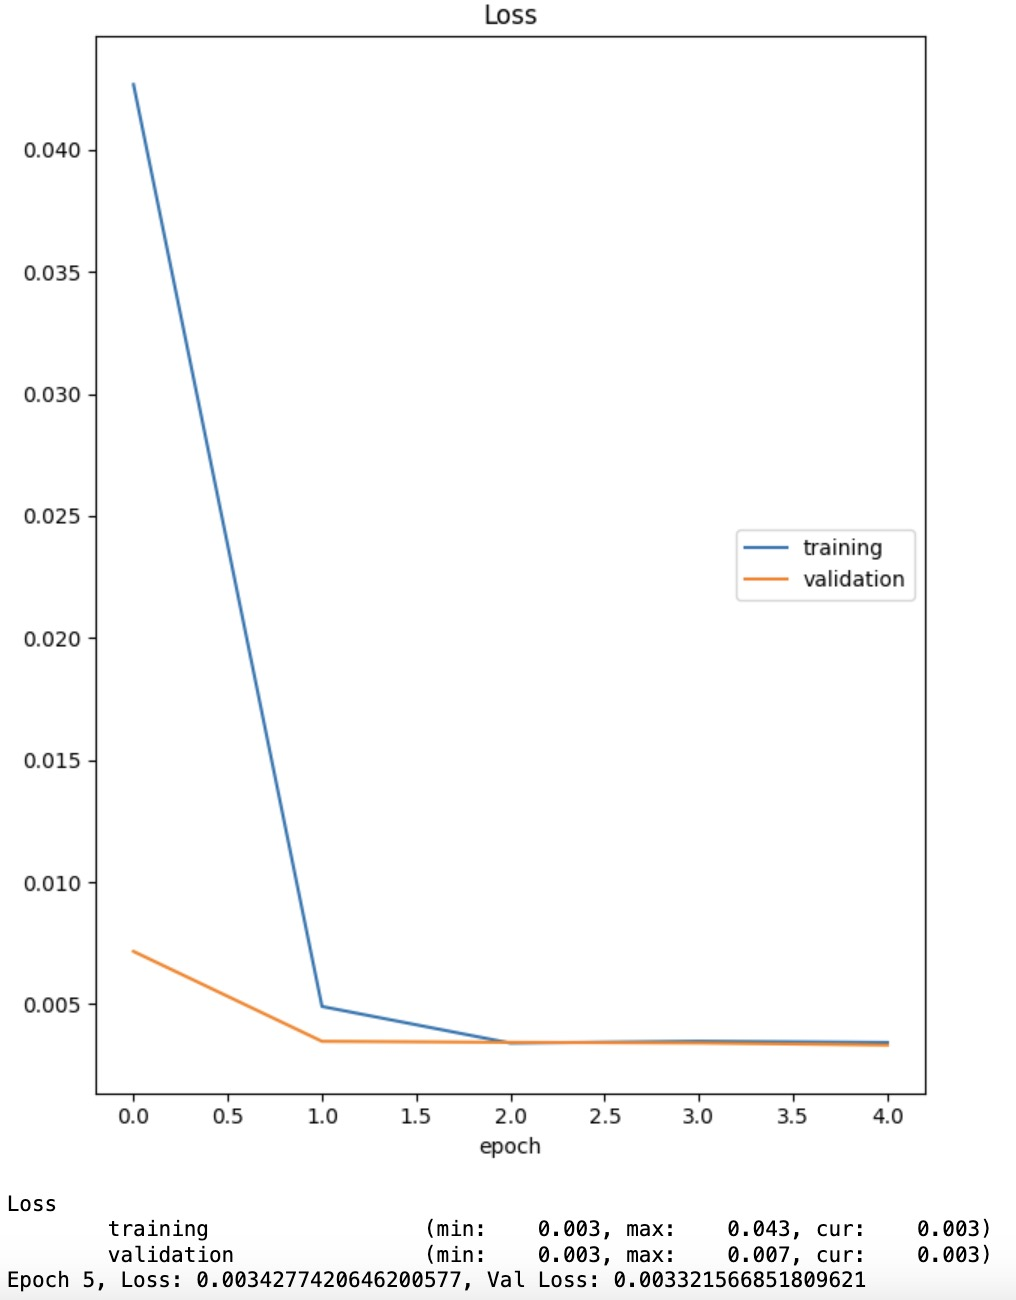

# Part 6: Prediction

### 6.1 Select the last six images and calculate the last three differences

In [85]:
cd /Users/pl/lilian

/Users/pl/lilian


In [86]:
image_path_minus6 = 'tst/tst_246.jpg'
image_path_minus5 = 'tst/tst_247.jpg'
image_path_minus4 = 'tst/tst_248.jpg'
image_path_minus3 = 'tst/tst_249.jpg'
image_path_minus2 = 'tst/tst_250.jpg'
image_path_minus1 = 'tst/tst_251.jpg'

image_minus6 = cv2.imread(image_path_minus6, cv2.IMREAD_GRAYSCALE).astype('int16')
image_minus5 = cv2.imread(image_path_minus5, cv2.IMREAD_GRAYSCALE).astype('int16')
image_minus4 = cv2.imread(image_path_minus4, cv2.IMREAD_GRAYSCALE).astype('int16')
image_minus3 = cv2.imread(image_path_minus3, cv2.IMREAD_GRAYSCALE).astype('int16')
image_minus2 = cv2.imread(image_path_minus2, cv2.IMREAD_GRAYSCALE).astype('int16')
image_minus1 = cv2.imread(image_path_minus1, cv2.IMREAD_GRAYSCALE).astype('int16')

In [87]:
model.eval()
train_max = 255
train_min = -255
input_difference = difference_tensor[-3:]
input_difference = (input_difference - train_min) / (train_max - train_min)
input_list = []
input_list.append(input_difference.unsqueeze(1))
input_list = torch.stack(input_list).float()
output_difference = model(input_list)[0].detach().numpy()
output_difference.shape

(3, 366, 366)

In [88]:
output_difference1 = output_difference[0] * (train_max - train_min) + train_min
output_difference2 = output_difference[1] * (train_max - train_min) + train_min
output_difference3 = output_difference[2] * (train_max - train_min) + train_min

### 6.2 Predict the future three images

In [89]:
image_prediction1 = image_minus3 + output_difference1
image_prediction2 = image_minus2 + output_difference2
image_prediction3 = image_minus1 + output_difference3

In [90]:
image_prediction1.max(),image_prediction1.min()

(210.06256, -43.189697)

In [91]:
image_prediction2.max(),image_prediction3.min()

(211.17014, -40.00766)

In [92]:
image_prediction3.max(),image_prediction3.min()

(224.5831, -40.00766)

In [94]:
cd /Users/pl/lilian

/Users/pl/lilian


In [95]:
processed_file_path1 = "./pred2/006.jpg"
processed_file_path2 = "./pred2/007.jpg"
processed_file_path3 = "./pred2/008.jpg"


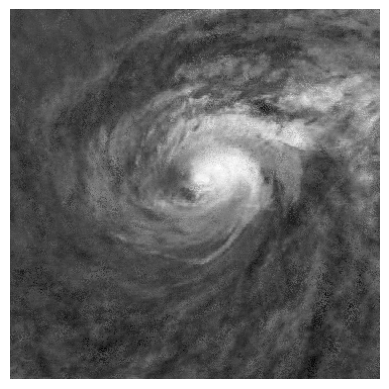

In [96]:
plt.imshow(image_prediction1, cmap='gray')
plt.axis('off')  
plt.savefig(processed_file_path1, bbox_inches='tight', pad_inches=0.0) 

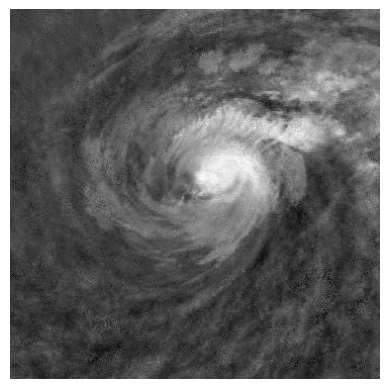

In [97]:
plt.imshow(image_prediction2, cmap='gray')
plt.axis('off') 
plt.savefig(processed_file_path2, bbox_inches='tight', pad_inches=0.0) 

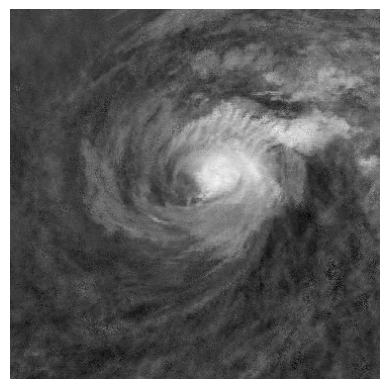

In [98]:
plt.imshow(image_prediction3, cmap='gray')
plt.axis('off') 
plt.savefig(processed_file_path3, bbox_inches='tight', pad_inches=0.0)  

### 6.3 create a gif to show the prediction images

In [99]:
cd /Users/pl/lilian

/Users/pl/lilian


In [100]:
from PIL import Image, ImageSequence
import numpy as np
import io

def create_gif(image_paths, folder_path, duration=200):
    """
    Create a GIF from a sequence of images.

    :param image_paths: List of image file paths.
    :param folder_path: Path to the folder containing the images.
    :param duration: Duration of each frame in the GIF (in milliseconds).
    :return: Bytes of the GIF image.
    """
    images = []

    # Load images and convert to grayscale
    for path in image_paths:
        img = Image.open(os.path.join(folder_path, path)).convert('L')
        images.append(img)

    # Save as GIF
    gif_buffer = io.BytesIO()
    images[0].save(gif_buffer, format='GIF', append_images=images[1:], save_all=True, duration=duration, loop=0)
    gif_buffer.seek(0)

    return gif_buffer

folder_path = "./pred2/"

jpg_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]
sorted_jpg_files = sorted(jpg_files)
# Create a GIF from the first 100 images
gif_buffer = create_gif(sorted_jpg_files[:], folder_path, duration=500)

# Save the GIF to a file
gif_file_path = './pred2/animated_montage.gif'
with open(gif_file_path, "wb") as f:
    f.write(gif_buffer.read())

gif_file_path

'./pred2/animated_montage.gif'

# Part 7: Save Model

In [101]:
# Assume your model is named 'model'
torch.save(model.state_dict(), 'CNN_LSTM_step_3_tst.pt')

# Later, you can recreate the model by loading the state dictionary
# First, you need to reconstruct the same model architecture
model = LSTMModel(seq_length=seq_length, forecast_horizon=forecast_horizon)
# Then, load the state dictionary
model.load_state_dict(torch.load('CNN_LSTM_step_3_tst.pt'))
# Don't forget to call model.eval() to set the dropout and batch normalization layers
# This is important for inference mode
model.eval()


LSTMModel(
  (cnn): CNN(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=1059968, out_features=256, bias=True)
  )
  (lstm): LSTM(256, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=401868, bias=True)
)

# Exploring Other Methods

## Classic Convolutional LSTM

Since this project deals with time sequencing, using a classic convolutional LSTM seemed like a good place to start to use as a baseline.

### Data Preprocessing
The original image sizes were 366x366, which took up took much RAM, so I blurred the images with GaussianBlur then used torch.nn.functional.interpolate. This produced low quality fuzzy images like this:

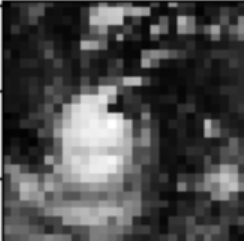

This makes since due to the fact that it is a very dramatic size change, so a lot of data was lost in the interpolation. However, quality was not as important since this was just a baseline model. For purposes of testing, the data was organized so that there was an input sequence and an output sequence, each sequence a length of 3. In the dataloader the batches were composed of a number of input and output sequences. The size of each batch was (batch_size, 3, 1, 28, 28). 

### LSTM Model
The architecture of the model is relatively simple, composed of one convolutional layer and one output linear layer.

LSTM_GEN(<br>
&nbsp;&nbsp;&nbsp;&nbsp;(lstm): LSTM(<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(rnn_cell_list): ModuleList(<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(0): LSTMCell(<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(conv): Conv2d(101, 400, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(h2o): Linear(in_features=78400, out_features=784, bias=True)<br>
&nbsp;&nbsp;&nbsp;&nbsp;)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(init): LSTMCell(<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(conv): Conv2d(101, 400, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))<br>
&nbsp;&nbsp;&nbsp;&nbsp;)<br>
)<br>

To make predictions, the input sequences were put into the model and then compared to the predicted sequence with nn.MSEloss(). The log loss ploss is below:

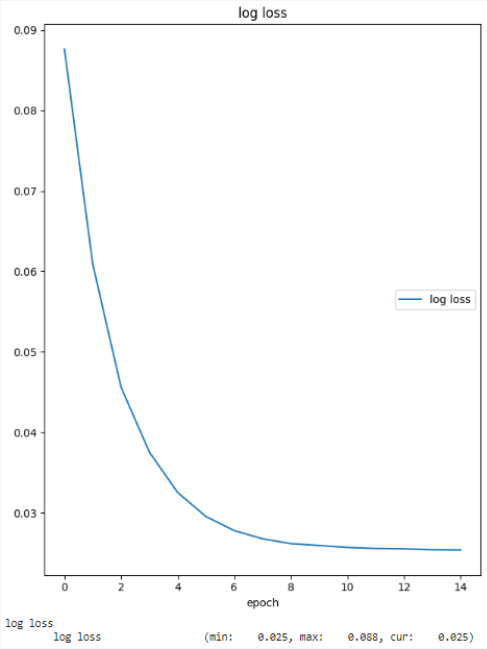 

The curve is very smooth, which suggests that the training was stable. In addition, the loss decreases, showing that the training is successful in keeping as much data as it can (although there was not much data there to begin with). Its accuracy was not as high as shown by the images below.

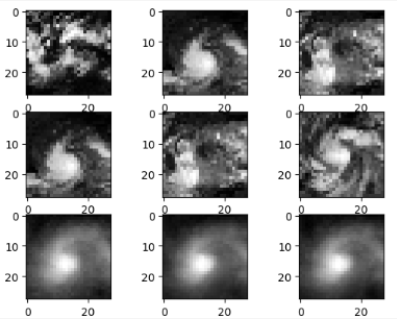 


(First row: Input sequence, Second row: Real 2nd sequence, Third row: predicted second sequence)

The first image looks good (relatively considering the input images), but the second and third images do not very closely resemble the actual images. The main reason for this has little to do with the model because the loss is very low as shown by the graph. Rather the reason for the inaccuracies and lack of quality in the images stem from the how the data was preprocessed. While resizing was necessary, it could have been done in a way where less features and image data were lost. The other models used improve on this in their preprocessing and make the model a bit more complex in order to produce higher quality images.

## Traditional Methods

Useful papers:
1. http://qikan.camscma.cn/en/article/id/200705105
2. https://www.researchgate.net/publication/227132073_Performance_Of_Optical_Flow_Techniques
3.  https://ieeexplore.ieee.org/document/


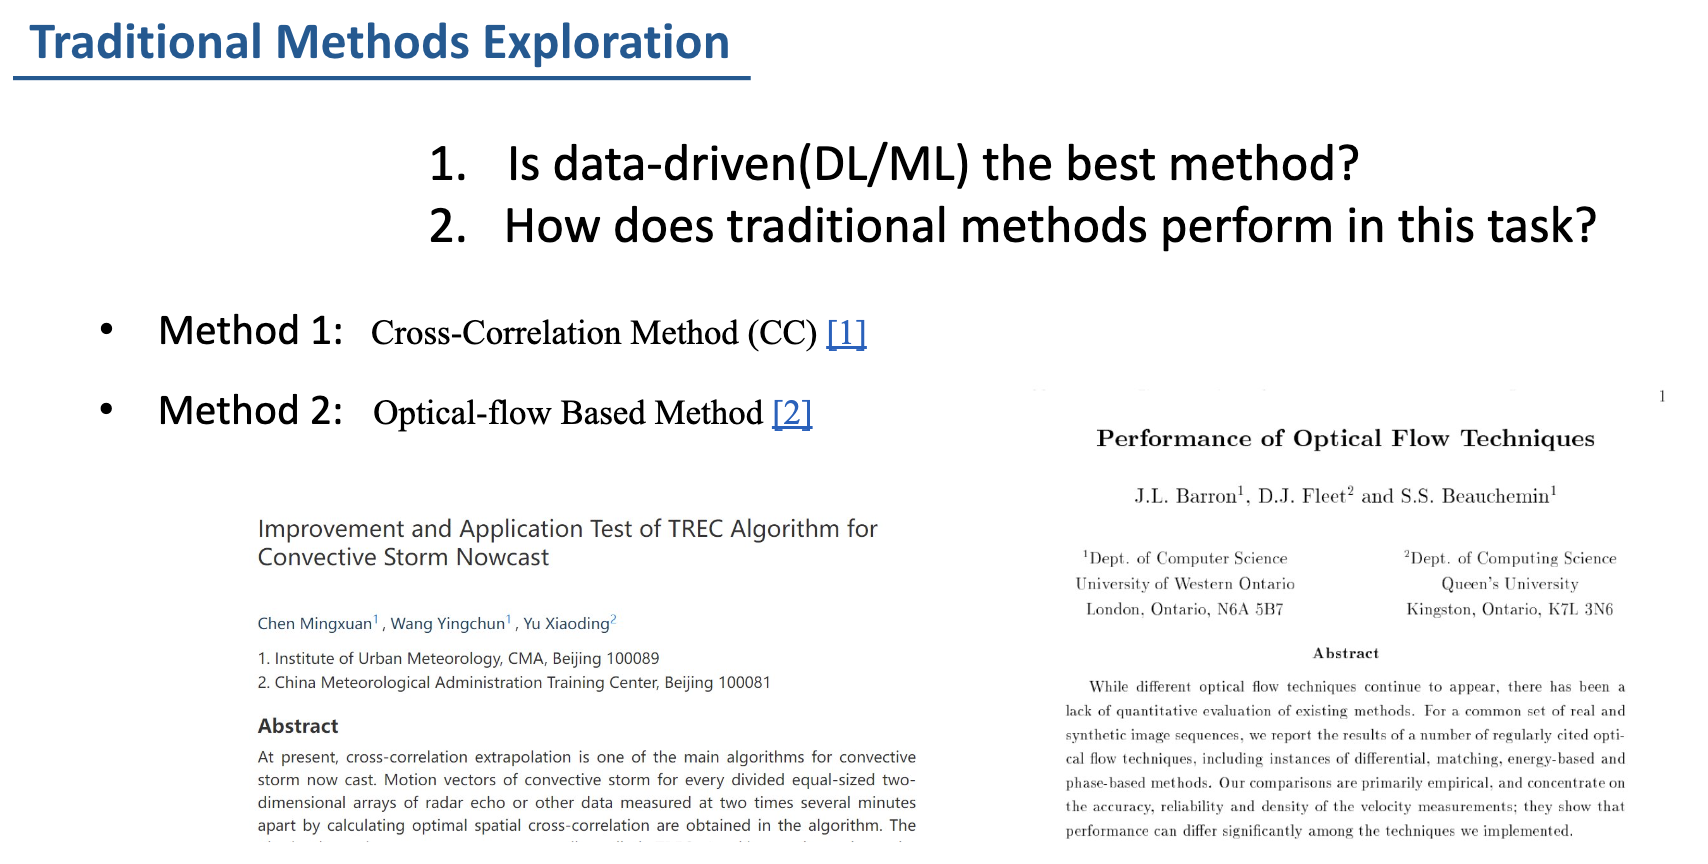 
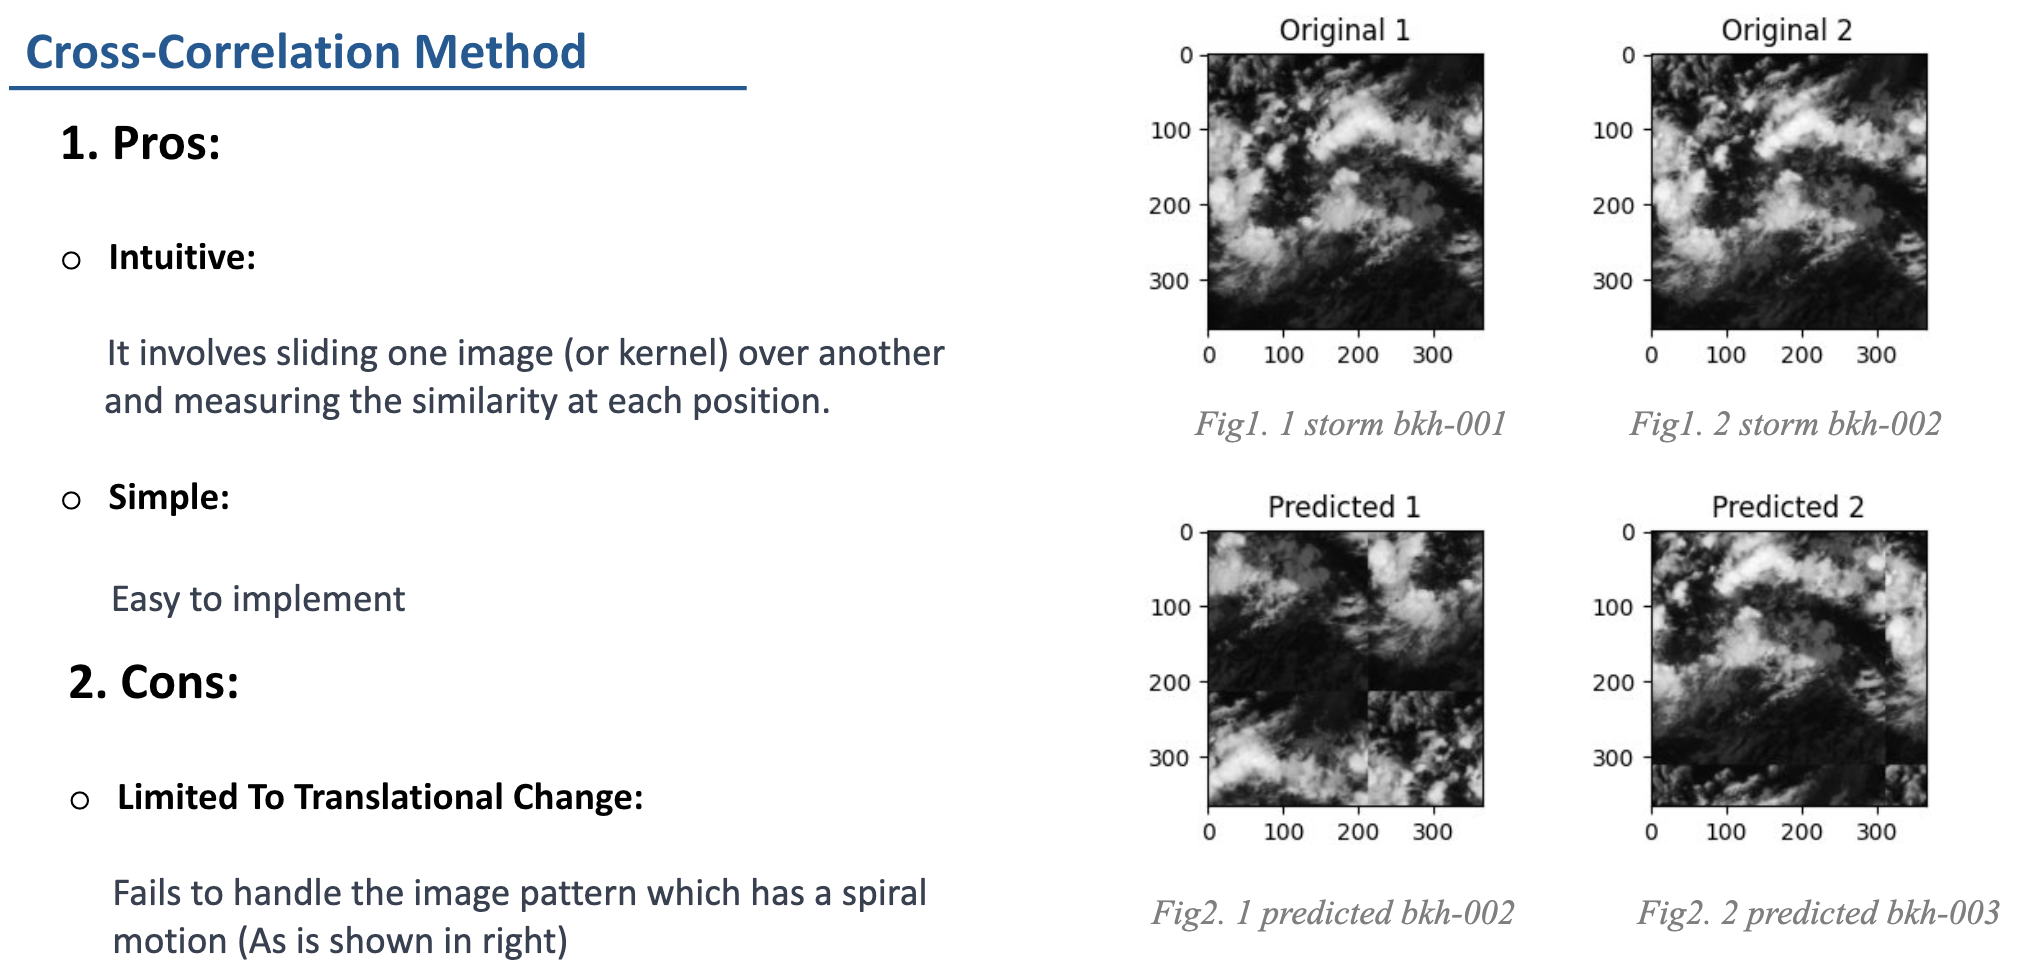 
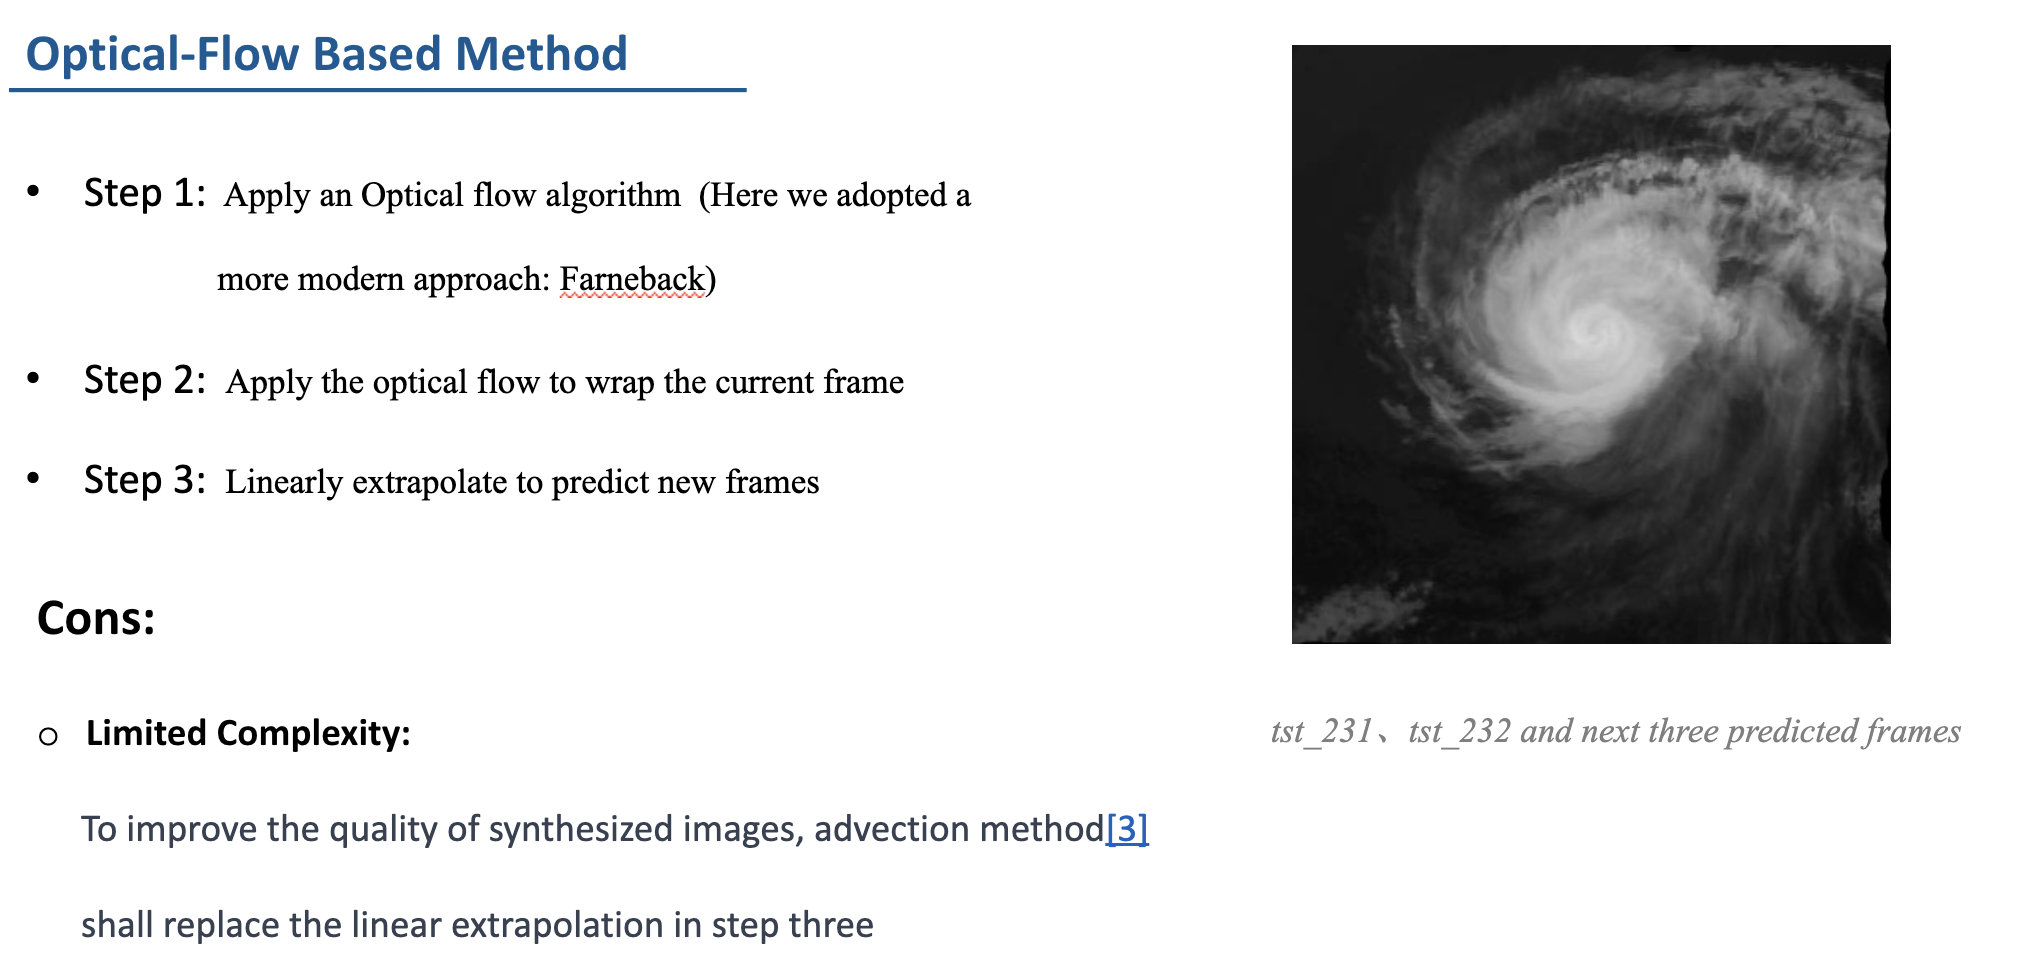